# Classification Project

The goal is to build a classification model to predict if median housing prices in some districts are below or above a certain level (150000).

Most steps (data inspection, transformation, etc.) in this notebook are similar to the steps in the regression notebook

## Python setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from scipy.stats import chi2_contingency, fisher_exact

import matplotlib.pyplot as plt


sns.set_theme()
%matplotlib inline

## Import Data/Data Ingestion

In [2]:
# import data 
# in this case I have used a formula from stackoverflow, because I was not able to make it work with ROOT + DATA or the other formulas from the notebooks
# Link to stackoverflow: https://stackoverflow.com/questions/55240330/how-to-read-csv-file-from-github-using-pandas 

url = "https://raw.githubusercontent.com/jan-kirenz/project-DanielSteck/main/project_data.csv?token=GHSAT0AAAAAABP5WYYS3N7LIECOFSXXBYGMYPLZQ3A"
df = pd.read_csv(url)

In [3]:
# check if data import was succesful
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0years,880,129.0,322,126,8.3252,452600.0$,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


**Explanation for the columns**
hier Hinweise zu den Daten (jede Zeile ist ein District):
- housing_median_age: Median age of a house within a district; a lower number is a newer building
- total_rooms: Total number of rooms within a district 
- total_bedrooms: Total number of bedrooms within a district
- population: Total number of people residing within a district
- households: Total number of households, a group of people residing within a home unit, for a district
- median_income: Median income for households within a district of houses (measured in tens of thousands of US Dollars)
- median_house_value: Median house value within a district (measured in US Dollars)
- ocean_proximity: Location of the district
- price_category: Indicator variable made from median_house_value (if median house value is below or above 150000)

**Identify Use Case**
We want to build a classification mode for the median house price for districts. Goal is to predict if the median house price is above or below 150000$. Therefore we want to train the data, evaluate models and test them with the test data set. Therefore we need to split the data before we start with the modelling.
We are owning a insurance company which wants to predict the prices of houses in certain districts based on various variables.

**Frame problem**
There are some variables in the table which are not necessary and can be dropped. Moreover we need to adjust the data in the table so that it can be worked with them. E.g. Data needs to be preprocessed, cleaned and variables need to be adjusted (total_rooms & total_bedrooms need to be adapted so that it is in average for each house).
For new districts we want to predict the house prices so that we can adapt our insurance model.


**Identify variables** 
- Our response variable is the median_house-value, which shall be predicted after we built the model and trained and tested it. If the price_category is set correclty then this is the response variable, to see if the price is above or below the median house price. Basically both variables are important as response variables for our model
- longitude and latitude can be dropped, that wont effect the data. Because both only make sense combined. Althought the location of a house affects the price, in this case both are only useful combined and each row display a whole district. So the longitude and latitude data it self wont affect the housing price in a logical order
- The price category needs to be double checked if the values are correct.
- housing_median__age is a useful variable and shall be used as a predictor
- total_rooms and total_bedrooms need to be reduced to the average per household otherwise it does not make sense
- population and household makes sense to use for the data model. Even thought both affect each other. If there are more people, there will be also more households. The data analysis will show how to use them
- median_income is a useful variable and shall be used as a predictor
- ocean_proximity is a useful variable and shall be used as a predictor

**Define metrics**
- The goal of our company is to predict as many house prices as possible correct out of the actual data. Therefore we want to misimze the false negatives and focus on a model with a high recall. Goal is to have a model with a recall value above 80%.

In [4]:
# show the first rows (head of the Dataframe)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0years,880,129.0,322,126,8.3252,452600.0$,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above


In [5]:
# show last rows
df.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above
20639,-121.24,39.37,16.0,2785,616.0,1387,530,2.3886,89400.0,INLAND,above


Note: 
> Direct Split in training and Test data plus split in validation and training data will be made at the end (if I have enough time for it), before that Ill try to finish all other exercises.
> In the Sprechstunde on 22.12: Feedback was that we do not need to make the cross validation process, that is why it is not included here


> Moreover I got the Feedback that the data errors shall be removed before the data split, that is why I removed the empty lines, adapted the wrong lines and tried to remove further data errors with the Cooks distance (see below in the removal of the Data errors and outliners). This was made because I saw from the EDA that there  are some data points included which can not be valid and the Cooks distance was the method which I knew to remove outliners and which worked. 

## Analyze & clean data

First line (line 0) has to wrong values (housing median age: 41years and median_house_value). Since there is only this row affected and the data seems correct, it will be manually adapted. 

Afterwards the data type can be changed to float64 (int64 would also be possible, but it might be possible, that there might decimal places)

In [6]:
# data overview (with meta data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  object 
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
 10  price_category      20640 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 1.7+ MB


In [7]:
# show all variables in the data set
df. columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'price_category'],
      dtype='object')

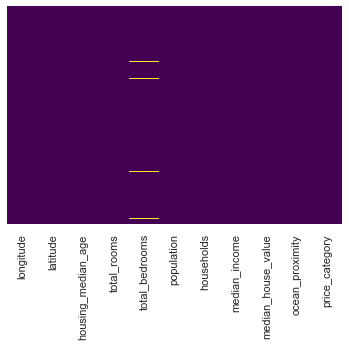

In [8]:
# show missing values (missing values - if present - will be displayed in yellow)
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [9]:
print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
price_category          0
dtype: int64


There are 207 lines where we do not have a value for the amount of total bedrooms!

### Data Transformation & Tidying data
What was learned from the data Inscpetion:
- First line (line 0) has to wrong values (housing median age: 41years and median_house_value). I will manually adjust these data, so that it will be correct, instead of dropping the whole line. Afterwards the data type can be changed to float64 (int64 would also be possible, but it might be possible, that there might decimal places)
- There are 207 lines where we do not have a value for the amount of total bedrooms!

In [10]:
# replace the data in line 0
df['housing_median_age'] = df['housing_median_age'].replace(['41.0years'], '41.0')
df['median_house_value'] = df['median_house_value'].replace(['452600.0$'], '452600.0')

# change data type
df['housing_median_age'] = pd.Float64Index(df['housing_median_age'])
df['median_house_value'] = pd.Float64Index(df['median_house_value'])
df['ocean_proximity'] =pd.Categorical(df['ocean_proximity'])
df['price_category'] =pd.Categorical(df['price_category'])

# check the data
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0,880,129.0,322,126,8.3252,452600.0,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


In [11]:
# check if the data types were changed succesfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  int64   
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  int64   
 6   households          20640 non-null  int64   
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
 10  price_category      20640 non-null  category
dtypes: category(2), float64(6), int64(3)
memory usage: 1.5 MB


In [12]:
# change column name, so that the naming is similar to the other colum names

df.rename(columns = {
    "housing_median_age": "median_housing_age"},
inplace=True)

df

,longitude,latitude,median_housing_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,price_category
0,-122.23,37.88,41.0,880,129.0,322,126,8.3252,452600.0,NEAR BAY,above
1,-122.22,37.86,21.0,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY,above
2,-122.24,37.85,52.0,1467,190.0,496,177,7.2574,352100.0,NEAR BAY,above
3,-122.25,37.85,52.0,1274,235.0,558,219,5.6431,341300.0,NEAR BAY,above
4,-122.25,37.85,52.0,1627,280.0,565,259,3.8462,342200.0,NEAR BAY,above
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665,374.0,845,330,1.5603,78100.0,INLAND,above
20636,-121.21,39.49,18.0,697,150.0,356,114,2.5568,77100.0,INLAND,above
20637,-121.22,39.43,17.0,2254,485.0,1007,433,1.7000,92300.0,INLAND,above
20638,-121.32,39.43,18.0,1860,409.0,741,349,1.8672,84700.0,INLAND,above


Dropping irrelevant features:
longitude, latitude wont affect the median_house_value.

In [13]:
# Drop irrelevant features
df = df.drop(['longitude', 'latitude'], axis=1)

Adding new colums to the table.

Background: Total_rooms & total_bedrooms is not comparable if in one district are 100 households and in one 500 households --> calculation per household
Also for the avg. size per household to see how big the household and therefore the flat is (even though it is already included in the avg_rooms_per_household)

Afterwards the total_rooms and total_bedrooms can be dropped, because it is already included via the avg_per_household

In [14]:
# calculate average rooms per household: total_rooms/households
df['avg_rooms_per_household'] = round(df['total_rooms']/df['households'],2)
# calculate average bedrooms per households: total_bedromms/ househols
df['avg_bedrooms_per_household'] = round(df['total_bedrooms']/df['households'],2)
# calculate average household size: population/households
df['avg_size_per_household'] = round(df['population']/df['households'],2)

# get the median income in $ and not in 10.000$
df['median_income']= df['median_income']*10000

df = df.drop(['total_rooms', 'total_bedrooms'], axis=1)

df

,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_bedrooms_per_household,avg_size_per_household
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,1.02,2.56
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,0.97,2.11
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,1.07,2.80
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,1.07,2.55
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,1.08,2.18
...,...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,above,5.05,1.13,2.56
20636,18.0,356,114,25568.0,77100.0,INLAND,above,6.11,1.32,3.12
20637,17.0,1007,433,17000.0,92300.0,INLAND,above,5.21,1.12,2.33
20638,18.0,741,349,18672.0,84700.0,INLAND,above,5.33,1.17,2.12


 **Update after Rücksprache: First split the data and afterwards add the median to the missing values, but in this case it is possible to drop these lines. Therefore all empty lines will be dropped**

In [15]:
# drop remaining rows with one missing value
df = df.dropna()

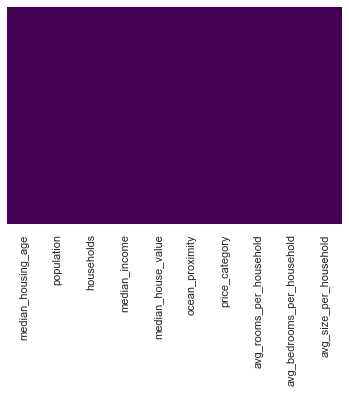

In [16]:
# show missing values --> Check if the lines were dropped successfully
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [17]:
# check column-wise distribution of null values
print(df.isnull().sum())

median_housing_age            0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
price_category                0
avg_rooms_per_household       0
avg_bedrooms_per_household    0
avg_size_per_household        0
dtype: int64


In [18]:
#summary statistics for all numerical colums (in transposed view)
round(df.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
median_housing_age,20433.0,28.63,12.59,1.00,18.00,29.00,37.00,52.00
population,20433.0,1424.95,1133.21,3.00,787.00,1166.00,1722.00,35682.00
households,20433.0,499.43,382.30,1.00,280.00,409.00,604.00,6082.00
median_income,20433.0,38711.62,18992.91,4999.00,25637.00,35365.00,47440.00,150001.00
median_house_value,20433.0,206864.41,115435.67,14999.00,119500.00,179700.00,264700.00,500001.00
avg_rooms_per_household,20433.0,5.43,2.48,0.85,4.44,5.23,6.05,141.91
avg_bedrooms_per_household,20433.0,1.10,0.48,0.33,1.01,1.05,1.10,34.07
avg_size_per_household,20433.0,3.07,10.44,0.69,2.43,2.82,3.28,1243.33


These values show that there a some data errors, it can be seen at the max value of avg_rooms_per_household, avg_bedrooms_per_household & avg_size_per_household. For avg rooms and bedrooms it might be possible (with very small chance) that there are only giant villas. Therefore I assume it is a data error. 
Moreover there wont be a houshold in which more than 1.200 people are living

Furthermore it can be seen, that avg_bedrooms_per_household wont bring any benefit to the data model regression, because 75% of these values are between 1.01 and 1.10. This minor changes wont affect the median housing price.





In [19]:
df = df.drop(['avg_bedrooms_per_household'], axis=1)

In [20]:
df['median_house_value'].median()

179700.0

The median housing price (to double check the 150000) will be calculated again after the data errors are removed. Because it is different to the 150000

In [21]:
#summary statistics for all categorical colums 
df.describe(include=['category'])

,ocean_proximity,price_category
count,20433,20433
unique,5,2
top,<1H OCEAN,above
freq,9034,16497


In [22]:
# show the 5 different data types in ocean_proximity
df.ocean_proximity.value_counts().index

CategoricalIndex(['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'], categories=['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], ordered=False, dtype='category')

#### Searching for data errors/outliners and removing them 
This will be done before the data set will be splitted (Feedback from Rücksprache on 22.12)

Analyse each column with boxplot charts to see if there are outliners in the data

<AxesSubplot:xlabel='median_housing_age'>

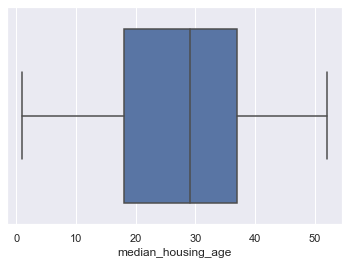

In [23]:
sns.boxplot(x='median_housing_age', data=df)

**Median_housing_Age** dows not have any data errors or outliners

<AxesSubplot:xlabel='population'>

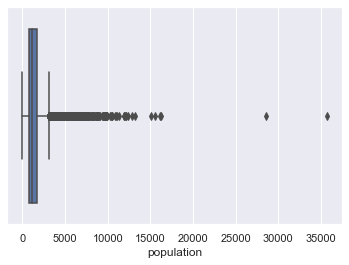

In [24]:
sns.boxplot(x='population', data=df)

Seems like there are some outliers/data errors for the **population** this shall be checked with Cooks distance

<AxesSubplot:xlabel='households'>

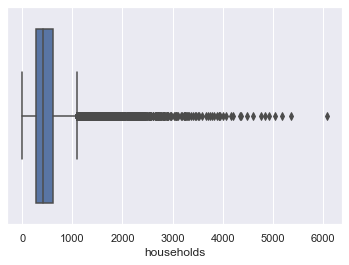

In [25]:
sns.boxplot(x='households', data=df)

Seems like there are some outliers/data errors for the **households** this shall be checked with Cooks distance

<AxesSubplot:xlabel='median_income'>

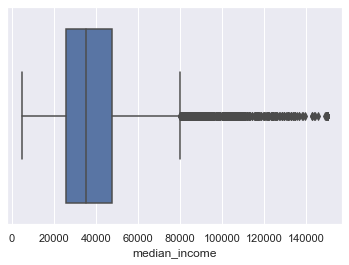

In [26]:
sns.boxplot(x='median_income', data=df)

Seems like there are some outliers/data errors for the **median_income** this shall be checked with Cooks distance

<AxesSubplot:xlabel='avg_rooms_per_household'>

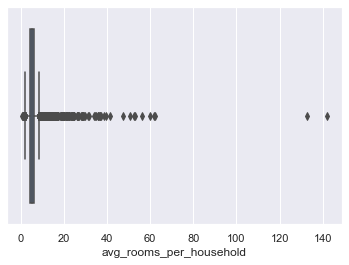

In [27]:
sns.boxplot(x='avg_rooms_per_household', data=df)

Seems like there are some outliers/data errors for the **avg_rooms_per_household** this shall be checked with Cooks distance

<AxesSubplot:xlabel='avg_size_per_household'>

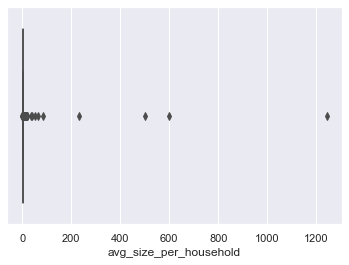

In [28]:
sns.boxplot(x='avg_size_per_household', data=df)

Seems like there are some outliers/data errors for the **avg_size_per_household** this shall be checked with Cooks distance

<AxesSubplot:xlabel='median_house_value'>

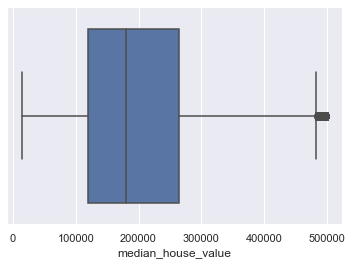

In [29]:
sns.boxplot(x='median_house_value', data=df)

Seems like there are some outliers/data errors for the **median_house_value** this shall be checked with Cooks distance

#### Cooks distance
First we need to create a model with all parameters so that the Cooks dinstance cann be calculated

In [30]:
df

,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_size_per_household
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,2.56
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,2.11
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,2.80
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,2.55
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,2.18
...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,above,5.05,2.56
20636,18.0,356,114,25568.0,77100.0,INLAND,above,6.11,3.12
20637,17.0,1007,433,17000.0,92300.0,INLAND,above,5.21,2.33
20638,18.0,741,349,18672.0,84700.0,INLAND,above,5.33,2.12


In [31]:
# create model with all parameters and save it as lm_cook, only numerical data will be used, due to the fact that I am looking for outliners
lm_cook = ols("median_house_value ~ median_housing_age + population + households + median_income + avg_rooms_per_household + avg_size_per_household", data=df).fit()

In [32]:
# print regression results
print(lm_cook.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4271.
Date:                Wed, 19 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:08:09   Log-Likelihood:            -2.5886e+05
No. Observations:               20433   AIC:                         5.177e+05
Df Residuals:                   20426   BIC:                         5.178e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2

We can see from the p-value of avg_size_per_household that this parameter has no effects on our model as it is higher than 5%. Therefore this column can be dropped

In [33]:
# Update column will not be dropped yet, first I want to analyze it with plots
# df = df.drop(['avg_size_per_household'], axis=1)

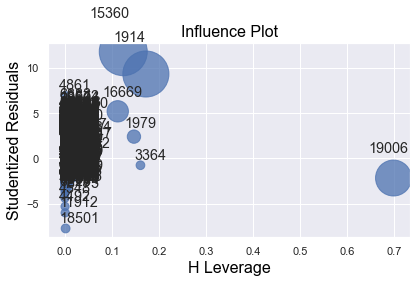

In [34]:
# Create an Influence Plot
fig = sm.graphics.influence_plot(lm_cook, criterion="cooks")
fig.tight_layout(pad=1.0)

To identify values with high influence, we look for observations with:

- big blue points (high Cook’s distance) and

- high leverage (X-axis) which additionally have

- high or low studentized residuals (Y-axis).

--> Outliners will be analyzed via Cooks distance

In [35]:
# obtains Cook's distance
fit_cooksd = lm_cook.get_influence().cooks_distance[0]

# get lenght of df to obtain n

n = len(df["median_housing_age"])

# calculate critical d
critical_d =4/n
print('Critical Cooks distance', critical_d)

# identification of potential outliers with Levarage
out_d = fit_cooksd > critical_d

# output potential outliers with levarage
print(df.index[out_d], "\n",
        fit_cooksd[out_d])

Critical Cooks distance 0.0001957617579405863
Int64Index([   61,    89,    95,   131,   395,   409,   457,   458,   459,
              460,
            ...
            20326, 20328, 20335, 20336, 20349, 20367, 20443, 20447, 20527,
            20544],
           dtype='int64', length=854) 
 [4.71212956e-04 1.07817157e-03 3.21094057e-03 3.20396586e-04
 2.13166505e-04 2.74493938e-04 4.61357513e-04 6.44901532e-04
 1.48043321e-03 6.21300257e-04 4.37862921e-04 2.34127202e-03
 7.02034472e-04 3.58656345e-04 3.99830978e-04 3.26240855e-04
 2.22896519e-04 1.98782920e-04 2.31951299e-04 6.38349418e-04
 2.27206419e-04 9.66811005e-04 2.64745826e-04 9.79105984e-04
 5.07249975e-04 1.96740592e-04 3.97496956e-04 2.97145105e-04
 2.48295613e-04 7.93857582e-04 4.14160027e-04 3.34677558e-04
 2.73633357e-04 1.24914048e-03 4.66233198e-03 3.17617964e-04
 6.08923858e-04 2.97546990e-04 7.49267555e-04 1.98214883e-04
 1.24544804e-03 4.57111064e-03 1.24588791e-03 4.28239340e-03
 9.53797859e-02 2.56762366e+00 3.70025

In [36]:
# drop the data which is identified as outliners by the cooks distance
df.drop(df.index[out_d], axis=0, inplace=True)

df

,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_size_per_household
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,2.56
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,2.11
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,2.80
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,2.55
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,2.18
...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,above,5.05,2.56
20636,18.0,356,114,25568.0,77100.0,INLAND,above,6.11,3.12
20637,17.0,1007,433,17000.0,92300.0,INLAND,above,5.21,2.33
20638,18.0,741,349,18672.0,84700.0,INLAND,above,5.33,2.12


Tidying up data was successfully made!

There were a lot of outliners in the data set. Before the outliners were removed, the data set contained 20433 rows and now only 19579.

Therefore there were **854** rows which were outliners 

--> this is a lot! Maybe I made somewhere a mistake...

In [37]:
df['median_house_value'].median()

175800.0

The median of the column **median_house_value** is 175.800$ and not 150.000$. Therefore I will make the analysis based on the calculated value for the median and not on the given value of 150.000!

**Update I have looked up the meaning of this column and it is fixed to 150.000 and not to the median of the median_house_price. Therefore the code below will be adapted**

The next step is to update the column price_category with the correct values. Also at some points this column (see tail of the dataframe) sasy a price of 77.100 is above the median (175800), so there seems to be some wrong data included. 

In [38]:
# update the column price category. All median_house_values below 150000 are classified as "below" and alls values with 150000 or more are classified as above
df['price_category'] = pd.cut(df['median_house_value'], 
                        bins = [0, 150000, float('inf')], 
                        labels = ['below', ' above'])

In [39]:
df

,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_size_per_household
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,2.56
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,2.11
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,2.80
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,2.55
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,2.18
...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,below,5.05,2.56
20636,18.0,356,114,25568.0,77100.0,INLAND,below,6.11,3.12
20637,17.0,1007,433,17000.0,92300.0,INLAND,below,5.21,2.33
20638,18.0,741,349,18672.0,84700.0,INLAND,below,5.33,2.12


In [40]:
# Note factorize() returns two objects: a label array and an array with the unique values
# Weare only interested in the first object.
# Above will be displayed as 0 and below will be displayed as 1
df['price_category2'] = df.price_category.factorize()[0]

df

,median_housing_age,population,households,median_income,median_house_value,ocean_proximity,price_category,avg_rooms_per_household,avg_size_per_household,price_category2
0,41.0,322,126,83252.0,452600.0,NEAR BAY,above,6.98,2.56,0
1,21.0,2401,1138,83014.0,358500.0,NEAR BAY,above,6.24,2.11,0
2,52.0,496,177,72574.0,352100.0,NEAR BAY,above,8.29,2.80,0
3,52.0,558,219,56431.0,341300.0,NEAR BAY,above,5.82,2.55,0
4,52.0,565,259,38462.0,342200.0,NEAR BAY,above,6.28,2.18,0
...,...,...,...,...,...,...,...,...,...,...
20635,25.0,845,330,15603.0,78100.0,INLAND,below,5.05,2.56,1
20636,18.0,356,114,25568.0,77100.0,INLAND,below,6.11,3.12,1
20637,17.0,1007,433,17000.0,92300.0,INLAND,below,5.21,2.33,1
20638,18.0,741,349,18672.0,84700.0,INLAND,below,5.33,2.12,1


0 = above
1 = below

## Distribution

Visualization of differences

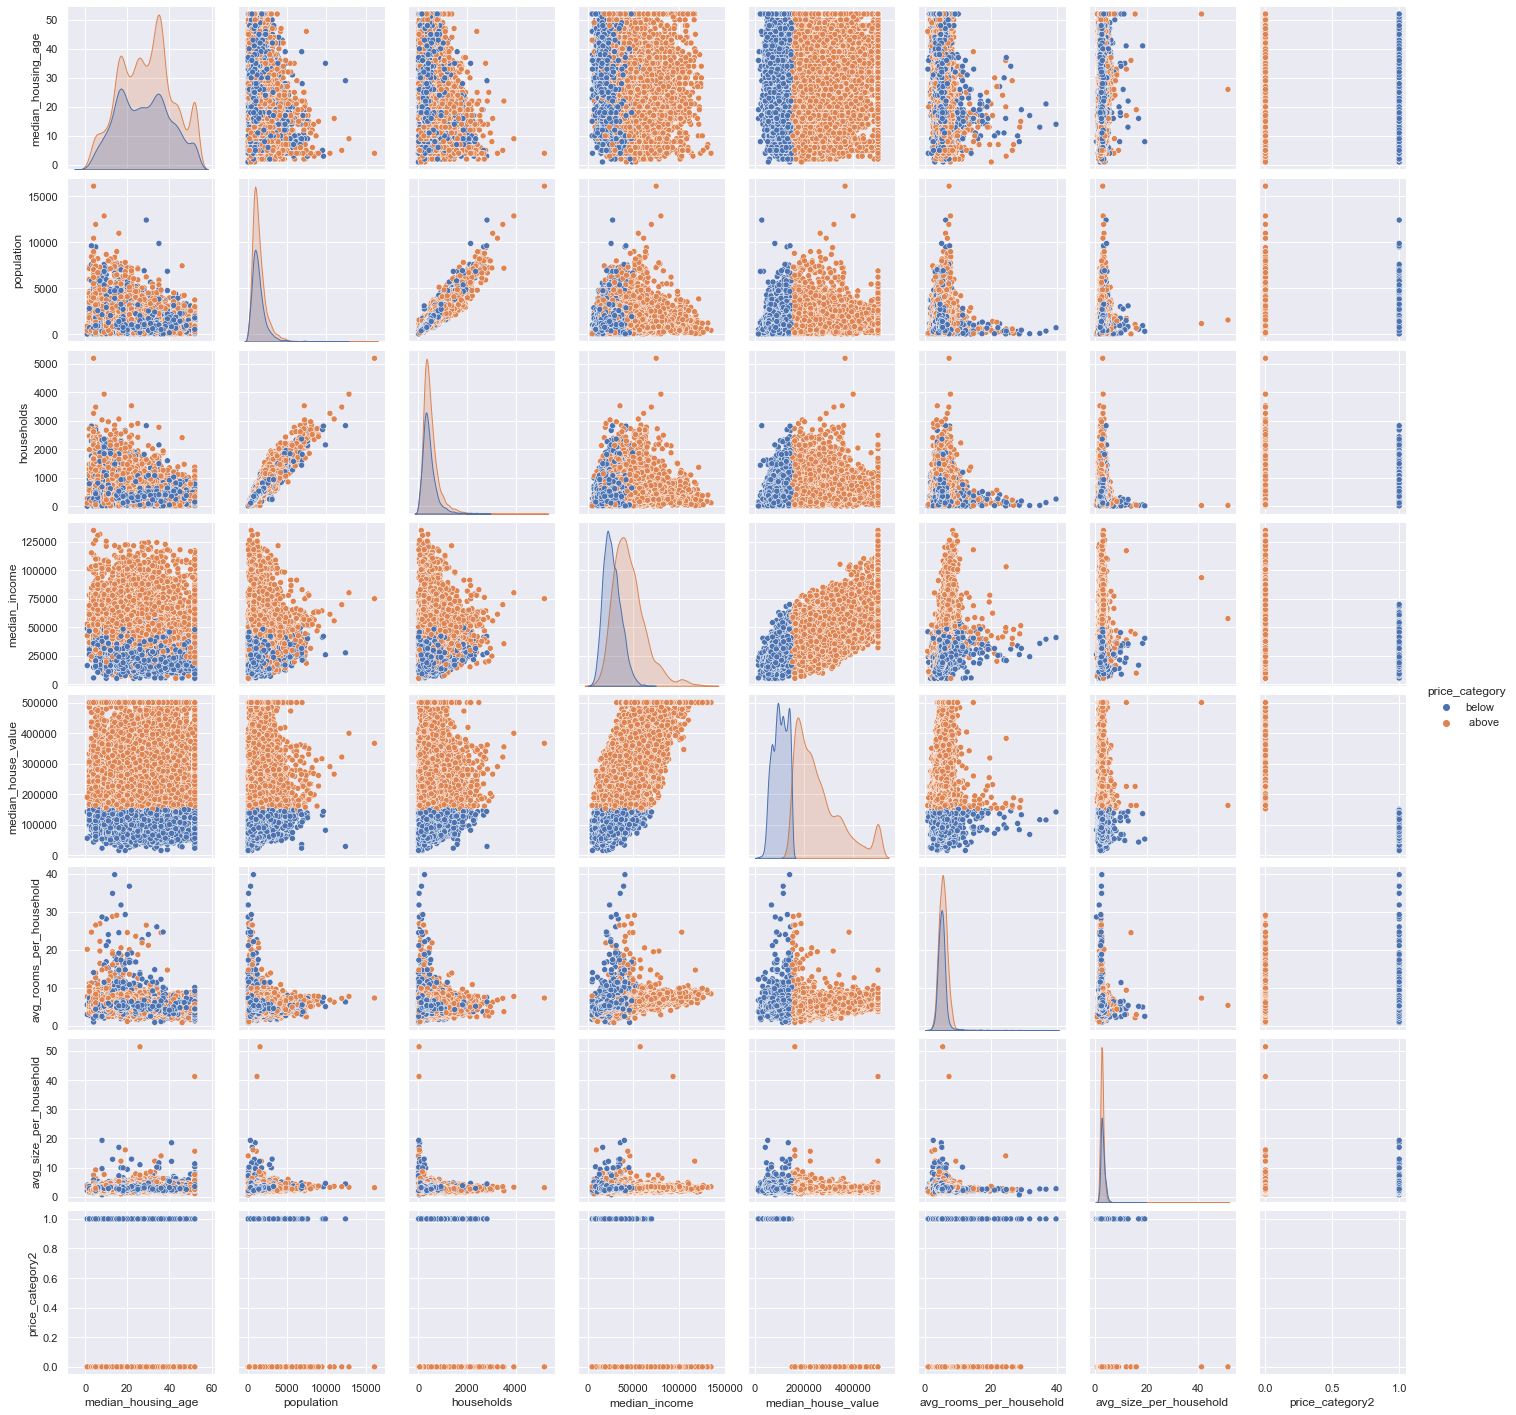

In [41]:
sns.pairplot(hue="price_category", data=df)

In [42]:
df.groupby(by=['price_category2']).describe().T

price_category2                            0              1
median_housing_age      count   12129.000000    7450.000000
                        mean       29.121939      27.817047
                        std        12.417939      12.338894
                        min         1.000000       1.000000
                        25%        19.000000      17.000000
                        50%        30.000000      28.000000
                        75%        37.000000      37.000000
                        max        52.000000      52.000000
population              count   12129.000000    7450.000000
                        mean     1427.647292    1333.011007
                        std      1000.802925     918.987308
                        min         8.000000       6.000000
                        25%       812.000000     762.250000
                        50%      1181.000000    1146.000000
                        75%      1749.000000    1658.000000
                        max     16122.000000   12427.000000
households              count   12129.000000    7450.000000
                        mean      511.809547     442.042282
                        std       348.750187     294.404986
                        min         2.000000       2.000000
                        25%       296.000000     259.000000
                        50%       426.000000     379.000000
                        75%       621.000000     548.000000
                        max      5189.000000    2826.000000
median_income           count   12129.000000    7450.000000
                        mean    45397.408525   26622.135973
                        std     17762.005343    9381.449241
                        min      4999.000000    4999.000000
                        25%     32792.000000   19729.000000
                        50%     42411.000000   25544.500000
                        75%     54409.000000   32500.000000
                        max    134883.000000   69903.000000
median_house_value      count   12129.000000    7450.000000
                        mean   259020.069750  102225.288188
                        std     94425.097070   29042.634880
                        min    150100.000000   14999.000000
                        25%    184600.000000   79800.000000
                        50%    231700.000000  102600.000000
                        75%    308300.000000  127100.000000
                        max    500001.000000  150000.000000
avg_rooms_per_household count   12129.000000    7450.000000
                        mean        5.499411       5.142779
                        std         1.519656       1.702846
                        min         0.850000       0.890000
                        25%         4.560000       4.350000
                        50%         5.410000       5.010000
                        75%         6.290000       5.660000
                        max        29.070000      39.760000
avg_size_per_household  count   12129.000000    7450.000000
                        mean        2.854143       3.094138
                        std         0.912595       0.908170
                        min         0.970000       0.690000
                        25%         2.400000       2.530000
                        50%         2.770000       2.940000
                        75%         3.180000       3.510000
                        max        51.400000      19.310000

The price category above has on average:
- **29.121939** as median_housing_age vs  **27.817047** for the price category below
- **1427.647292** as population vs **1333.011007** for the price category below
- **511.809547** as households vs **442.042282** for the price category below
- **45397.408525** as median_income vs **26622.135973** for the price category below
- **median_house_value** will be skipped, because the price category is based on this feature
- **5.499411** as avg_rooms_per_household vs **5.142779** for the price category below

--> for all these features the mean is higher for the price_category above

- **2.854143** as avg_size_per_household vs **3.094138** for the price category below
--> here the mean for the price_category below, which also makes sense, because people with more money can afford to life on their owen. Moreover those people often focus more on their careers instead of their family (my interpretation)

<AxesSubplot:xlabel='median_housing_age', ylabel='Density'>

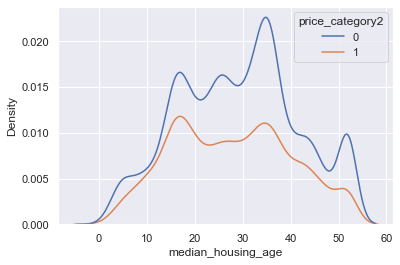

In [43]:
sns.kdeplot(hue="price_category2", x='median_housing_age', data=df)

Only a minor difference can be seen here (two peakes for price category above). 

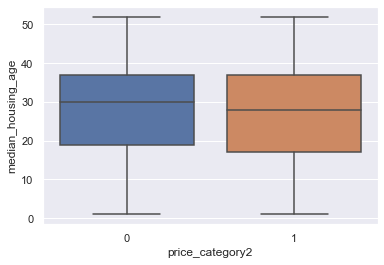

In [44]:
sns.boxplot(x="price_category2", y="median_housing_age", data=df);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='population', ylabel='Density'>

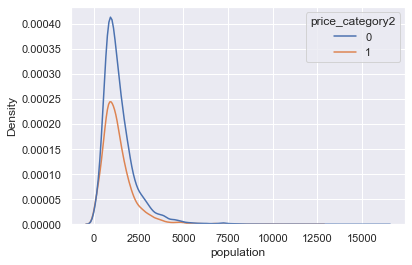

In [45]:
sns.kdeplot(hue="price_category2", x='population', data=df)

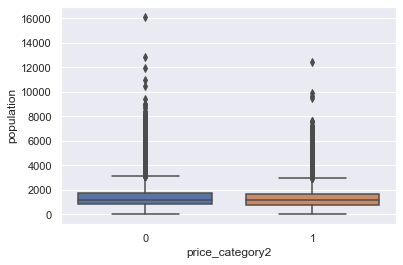

In [46]:
sns.boxplot(x="price_category2", y="population", data=df);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='households', ylabel='Density'>

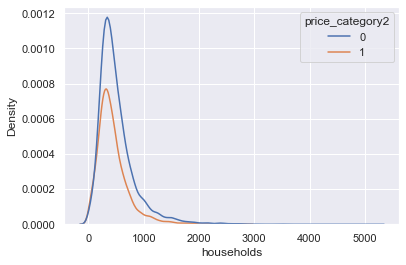

In [47]:
sns.kdeplot(hue="price_category2", x='households', data=df)

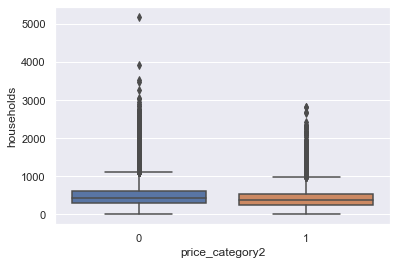

In [48]:
sns.boxplot(x="price_category2", y="households", data=df);

Only a minor difference can be seen here, but it is very small

<AxesSubplot:xlabel='median_income', ylabel='Density'>

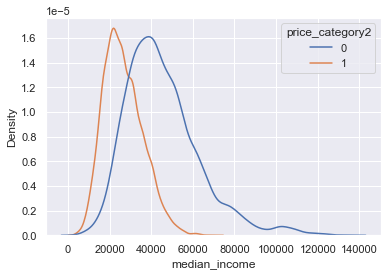

In [49]:
sns.kdeplot(hue="price_category2", x='median_income', data=df)

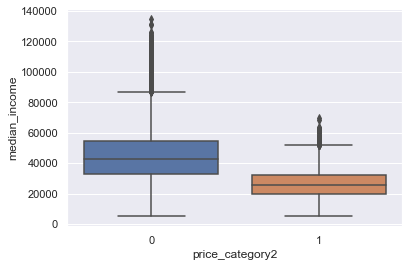

In [50]:
sns.boxplot(x="price_category2", y="median_income", data=df);

For this variable a difference can be seen. The median income is higher for the price category above!


<AxesSubplot:xlabel='avg_rooms_per_household', ylabel='Density'>

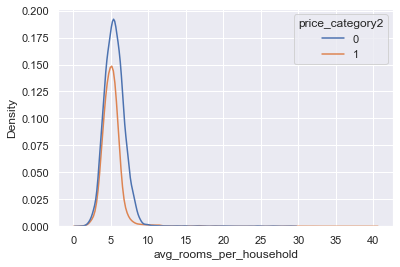

In [51]:
sns.kdeplot(hue="price_category2", x='avg_rooms_per_household', data=df)

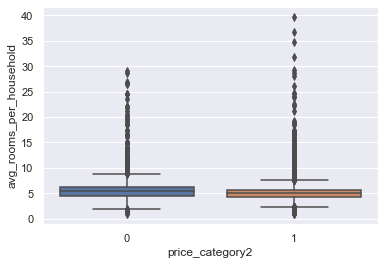

In [52]:
sns.boxplot(x="price_category2", y="avg_rooms_per_household", data=df);

Almost no difference can be seen, in the first plot a the plot for price category above is a bit more on the right, which indicates a higher amount of avg_rooms_per_household

<AxesSubplot:xlabel='avg_size_per_household', ylabel='Density'>

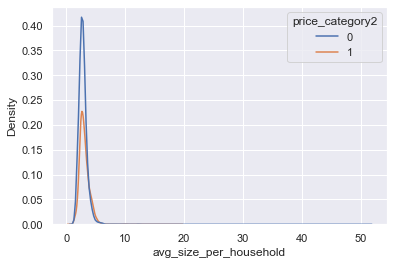

In [53]:
sns.kdeplot(hue="price_category2", x='avg_size_per_household', data=df)

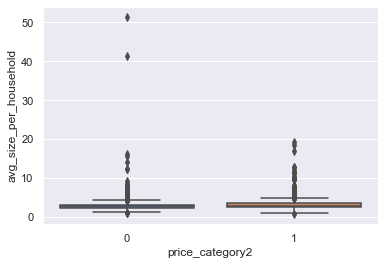

In [54]:
sns.boxplot(x="price_category2", y="avg_size_per_household", data=df);

No difference can be seen here

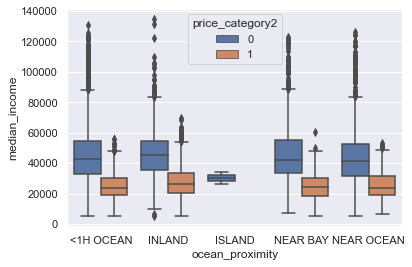

In [55]:
sns.boxplot(x="ocean_proximity", y="median_income", hue="price_category2", data=df);

To be honest, I can not interpretate this. It looks like there is no influence.
It would be also possible to use median_house_value instead of median_income. But I do not know if this is possible(allowed), because my price_category is based on the median_house_value

## Correlation


In [56]:
# Create correlation matrix for numerical variables
# Zusammenhang zwischen 2 Variablen, korrelationskoeffizient bewegt sich zwischen -1 und +1
corr_matrix = df.corr()
corr_matrix

,median_housing_age,population,households,median_income,median_house_value,avg_rooms_per_household,avg_size_per_household,price_category2
median_housing_age,1.000000,-0.308183,-0.317670,-0.145890,0.089479,-0.218036,0.011086,-0.051078
population,-0.308183,1.000000,0.921790,0.024361,-0.010551,-0.065992,0.149189,-0.047294
households,-0.317670,0.921790,1.000000,0.036074,0.075767,-0.068740,-0.124106,-0.102380
median_income,-0.145890,0.024361,0.036074,1.000000,0.747953,0.500303,-0.056293,-0.516066
median_house_value,0.089479,-0.010551,0.075767,0.747953,1.000000,0.249492,-0.201670,-0.705624
avg_rooms_per_household,-0.218036,-0.065992,-0.068740,0.500303,0.249492,1.000000,-0.053757,-0.108140
avg_size_per_household,0.011086,0.149189,-0.124106,-0.056293,-0.201670,-0.053757,1.000000,0.126889
price_category2,-0.051078,-0.047294,-0.102380,-0.516066,-0.705624,-0.108140,0.126889,1.000000


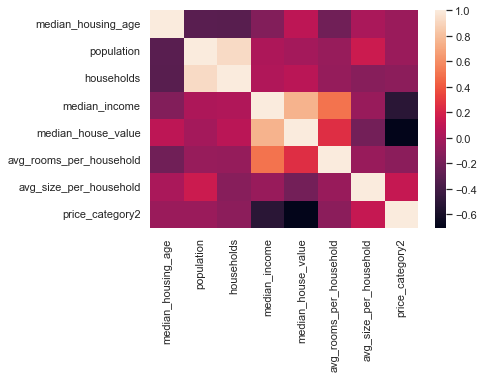

In [57]:
# Simple heatmap
heatmap = sns.heatmap(corr_matrix)

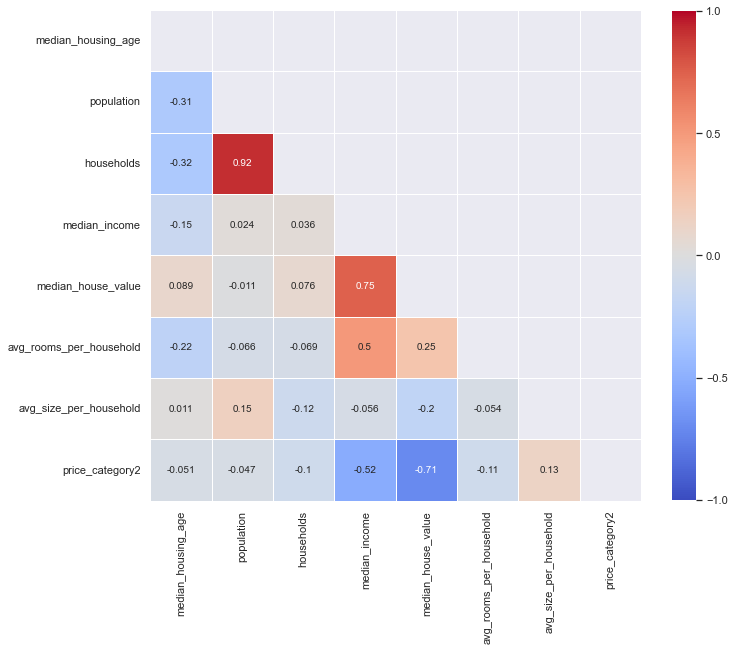

In [58]:
# Make a pretty heatmap

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Change size
plt.subplots(figsize=(11, 15))

# Build heatmap with additional options
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

It can be seen that 2 variables have a big impact on the price_category2. On the one hand the median_income and on the other hand the median_house_value. The problem is that the seconed variable is included from our model as it already includes the solution, therefore it can not be added to the model.

Due to that I will create the following models:
- Model with all variables
- Model with only median_income 
- Model with the selected variables from the feature selection in the regression notebook (median_income + ocean_proximity)

### VIF factor

In [59]:
from patsy import dmatrices

y, X =dmatrices('price_category2 ~ median_housing_age + population + households + median_income + avg_rooms_per_household + avg_size_per_household ', df, return_type='dataframe')

# For each X. calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["Feature"] = X.columns

vif.round(2)

,VIF Factor,Feature
0,54.86,Intercept
1,1.19,median_housing_age
2,12.58,population
3,12.62,households
4,1.34,median_income
5,1.42,avg_rooms_per_household
6,1.93,avg_size_per_household


### Adding dummy variables for ocean Proximity to the data frame

In [60]:
# change the column Ocean Proximity to dummy variables
dummies = pd.get_dummies(df[['ocean_proximity']])

In [61]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ocean_proximity_<1H OCEAN   19579 non-null  uint8
 1   ocean_proximity_INLAND      19579 non-null  uint8
 2   ocean_proximity_ISLAND      19579 non-null  uint8
 3   ocean_proximity_NEAR BAY    19579 non-null  uint8
 4   ocean_proximity_NEAR OCEAN  19579 non-null  uint8
dtypes: uint8(5)
memory usage: 764.6 KB


In [62]:
print(dummies.head)

<bound method NDFrame.head of        ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  \
0                              0                       0   
1                              0                       0   
2                              0                       0   
3                              0                       0   
4                              0                       0   
...                          ...                     ...   
20635                          0                       1   
20636                          0                       1   
20637                          0                       1   
20638                          0                       1   
20639                          0                       1   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
0                           0                         1   
1                           0                         1   
2                           0                         1   
3            

## Logistic Regression
## Model with all predictors

Now I will try to solve this the same way as it was made in the Online_ads, below I tried it the same way as it was in the worl happiness report
### Define features:

In [63]:
# drop median house value (as it is will be included in y, drop price_category as we want to predict it and drop ocean_proximity as it will be added via the dummy variables)
X_numerical = df.drop(['median_house_value', 'price_category', 'price_category2', 'ocean_proximity'], axis=1).astype('float64')

In [64]:
list_numerical = X_numerical.columns
list_numerical

Index(['median_housing_age', 'population', 'households', 'median_income',
       'avg_rooms_per_household', 'avg_size_per_household'],
      dtype='object')

In [65]:
X = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

y = df.price_category2

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_housing_age          19579 non-null  float64
 1   population                  19579 non-null  float64
 2   households                  19579 non-null  float64
 3   median_income               19579 non-null  float64
 4   avg_rooms_per_household     19579 non-null  float64
 5   avg_size_per_household      19579 non-null  float64
 6   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 7   ocean_proximity_INLAND      19579 non-null  uint8  
 8   ocean_proximity_ISLAND      19579 non-null  uint8  
 9   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 10  ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(6), uint8(5)
memory usage: 1.6 MB


### Data split

In [66]:
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=10)

### Model

In [67]:
# for the first model all features are selected
features_model = ['median_housing_age', 'population', 'households', 'median_income', 'avg_rooms_per_household', 'avg_size_per_household', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']

X_train = X_train[features_model]
X_test = X_test[features_model]

In [68]:
import sklearn.linear_model as skl_lm

# model
clf = skl_lm.LogisticRegressionCV(penalty='l2')
# prediction
y_pred = clf.fit(X_train, y_train).predict(X_test)

C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

### Classification metrics

In [69]:
# return the mean accuracy on the given test data and labels
clf.score(X_test, y_test)

0.8329928498467825

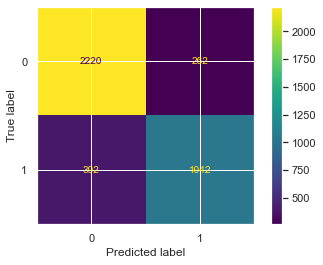

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=clf.classes_)

disp.plot()
plt.show()

In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.85      0.89      0.87      2482
         Yes       0.80      0.73      0.76      1434

    accuracy                           0.83      3916
   macro avg       0.82      0.81      0.82      3916
weighted avg       0.83      0.83      0.83      3916



Values for precision, recall und f1-score are quite good

### Thresholds

In [72]:
pred_proba = clf.predict_proba(X_test)

### Threshold 0.4

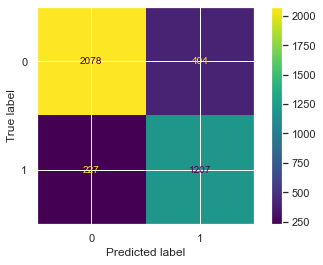

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2482
           1       0.75      0.84      0.79      1434

    accuracy                           0.84      3916
   macro avg       0.83      0.84      0.83      3916
weighted avg       0.85      0.84      0.84      3916



In [73]:
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .4})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)

disp.plot()
plt.show()

print(classification_report(y_test, df_['y_pred']))

Predictions were even better, all values for precision, recall and f1-score have increased

### Threshold 0.5

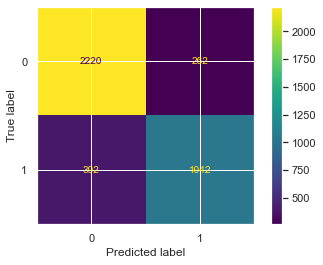

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2482
           1       0.80      0.73      0.76      1434

    accuracy                           0.83      3916
   macro avg       0.82      0.81      0.82      3916
weighted avg       0.83      0.83      0.83      3916



In [74]:
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .5})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)

disp.plot()
plt.show()

print(classification_report(y_test, df_['y_pred']))

Same values as for the initial model (which automatically starts with the 0.5 threshold)

### Threshold 0.7

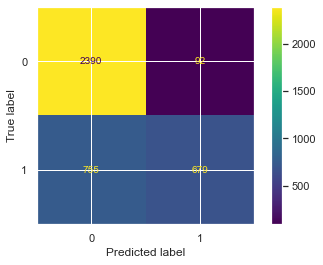

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      2482
           1       0.88      0.47      0.62      1434

    accuracy                           0.78      3916
   macro avg       0.82      0.72      0.73      3916
weighted avg       0.80      0.78      0.76      3916



In [75]:
df_ = pd.DataFrame({'y_test': y_test, 'y_pred': pred_proba[:,1] > .7})
cm = confusion_matrix(y_test, df_['y_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)

disp.plot()
plt.show()

print(classification_report(y_test, df_['y_pred']))

Recall and f1-score decreased. Therefore the threshold 0.4 is the best

## Model with results from feature selection
### Define x and y

In this model only the variables which were analyzed in the feature selection are used. So only the median_income and ocean_proximity as x will be used here. 
Goal is to make correct predictions for the price category (in this case the factorized price_category_2 is used for y)

In [76]:
# drop everything except median_income - somehow it did not work wenn I only used median_income and did not drop anything
X_2_numerical = df.drop(['median_housing_age', 'population', 'households', 'avg_rooms_per_household', 'median_house_value', 'price_category', 'price_category2', 'ocean_proximity', 'avg_size_per_household'], axis=1).astype('float64')

In [77]:
list_2_numerical = X_2_numerical.columns
list_2_numerical

Index(['median_income'], dtype='object')

In [78]:
X_2 = pd.concat([X_2_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

y_2 = df.price_category2

X_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_income               19579 non-null  float64
 1   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 2   ocean_proximity_INLAND      19579 non-null  uint8  
 3   ocean_proximity_ISLAND      19579 non-null  uint8  
 4   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 5   ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(1), uint8(5)
memory usage: 917.6 KB


### Data split

In [79]:
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
from sklearn.model_selection import train_test_split

X_2_train, X_2_test, y_2_train, y_2_test =train_test_split(X, y, test_size=0.2, random_state=10)

In [80]:
# for this  model only median_income and ocean_proximity is selected
features_model_2 = ['median_income', 'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']

X_2_train = X_2_train[features_model_2]
X_2_test = X_2_test[features_model_2]

In [81]:
import sklearn.linear_model as skl_lm

# model
clf_2 = skl_lm.LogisticRegressionCV(penalty='l2')
# prediction
y_2_pred = clf_2.fit(X_2_train, y_2_train).predict(X_2_test)

### Classification metrics

In [82]:
# return the mean accuracy on the given test data and labels
clf_2.score(X_2_test, y_2_test)

0.8442288049029623

Score is higher than for the first model

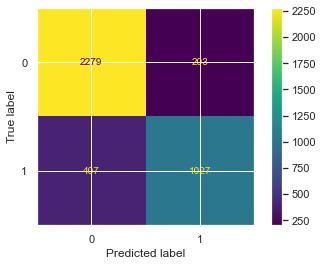

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_2_test, y_2_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=clf_2.classes_)

disp.plot()
plt.show()

In [84]:
from sklearn.metrics import classification_report

print(classification_report(y_2_test, y_2_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.85      0.92      0.88      2482
         Yes       0.83      0.72      0.77      1434

    accuracy                           0.84      3916
   macro avg       0.84      0.82      0.83      3916
weighted avg       0.84      0.84      0.84      3916



This model delivers better values for precision, recall and for the f1-score!

### Thresholds

In [85]:
pred_proba = clf_2.predict_proba(X_2_test)

### Threshold 0.4

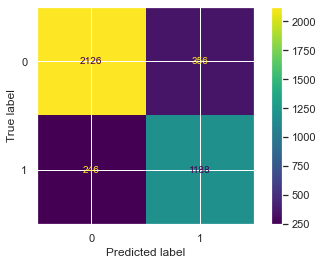

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2482
           1       0.77      0.83      0.80      1434

    accuracy                           0.85      3916
   macro avg       0.83      0.84      0.84      3916
weighted avg       0.85      0.85      0.85      3916



In [86]:
df_2 = pd.DataFrame({'y_2_test': y_2_test, 'y_2_pred': pred_proba[:,1] > .4})
cm = confusion_matrix(y_2_test, df_2['y_2_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf_2.classes_)

disp.plot()
plt.show()

print(classification_report(y_2_test, df_2['y_2_pred']))

Values for precision has decreased, but recall and f1-score has increased --> because f1-score is higher, this threshold performs better than the threshold 0.5
Moreover these values are better than those for model 1

### Threshold 0.5

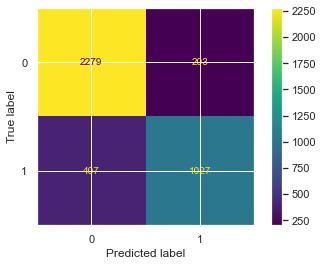

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2482
           1       0.83      0.72      0.77      1434

    accuracy                           0.84      3916
   macro avg       0.84      0.82      0.83      3916
weighted avg       0.84      0.84      0.84      3916



In [87]:
df_2 = pd.DataFrame({'y_2_test': y_2_test, 'y_2_pred': pred_proba[:,1] > .5})
cm = confusion_matrix(y_2_test, df_2['y_2_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf_2.classes_)

disp.plot()
plt.show()

print(classification_report(y_2_test, df_2['y_2_pred']))

Same values as for the initial model (which automatically starts with the 0.5 threshold)

### Threshold 0.7

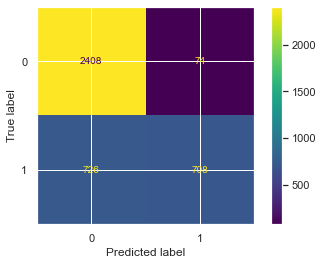

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      2482
           1       0.91      0.49      0.64      1434

    accuracy                           0.80      3916
   macro avg       0.84      0.73      0.75      3916
weighted avg       0.82      0.80      0.78      3916



In [88]:
df_2 = pd.DataFrame({'y_2_test': y_2_test, 'y_2_pred': pred_proba[:,1] > .7})
cm = confusion_matrix(y_2_test, df_2['y_2_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf_2.classes_)

disp.plot()
plt.show()

print(classification_report(y_2_test, df_2['y_2_pred']))

All values are lower than for the 0.5 threshold.
Therefore threshold 0.4 is the best

## Model with Median_income as only variable
### Define x and y

In this model only the variable which was analyzed in the correlation analysis and plots is used. So only the median_income as x will be used here. 
Goal is to make correct predictions for the price category (in this case the factorized price_category_2 is used for y)

Note:
> I swapped the positions for this model and the previous model, thats why the numbers_1 and _2 are the wrong way around

In [89]:
# drop everything except median_income - somehow it did not work wenn I only used median_income and did not drop anything
X_1_numerical = df.drop(['median_housing_age', 'population', 'households', 'avg_rooms_per_household', 'median_house_value', 'price_category', 'price_category2', 'ocean_proximity', 'avg_size_per_household'], axis=1).astype('float64')

In [90]:
list_1_numerical = X_1_numerical.columns
list_1_numerical

Index(['median_income'], dtype='object')

In [91]:
X_1 = X_1_numerical
y_1 = df.price_category2

X_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   median_income  19579 non-null  float64
dtypes: float64(1)
memory usage: 822.0 KB


### Data split

In [92]:
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
from sklearn.model_selection import train_test_split

X_1_train, X_1_test, y_1_train, y_1_test =train_test_split(X_1, y_1, test_size=0.2, random_state=10)

X_1_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3916 entries, 11395 to 5013
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   median_income  3916 non-null   float64
dtypes: float64(1)
memory usage: 61.2 KB


In [93]:
# for this  model only median_income  is selected
features_model_1 = ['median_income']

X_1_train = X_1_train[features_model_1]
X_1_test = X_1_test[features_model_1]

In [94]:
import sklearn.linear_model as skl_lm

# model
clf_1 = skl_lm.LogisticRegressionCV(penalty='l2')
# prediction
y_1_pred = clf_1.fit(X_1_train, y_1_train).predict(X_1_test)

C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Daniel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

### Classification metrics

In [95]:
# return the mean accuracy on the given test data and labels
clf_1.score(X_1_test, y_1_test)

0.7576608784473953

this model has the lowest score

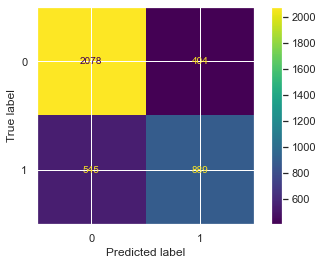

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_1_test, y_1_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                        display_labels=clf_1.classes_)

disp.plot()
plt.show()

In [97]:
from sklearn.metrics import classification_report

print(classification_report(y_1_test, y_1_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.79      0.84      0.81      2482
         Yes       0.69      0.62      0.65      1434

    accuracy                           0.76      3916
   macro avg       0.74      0.73      0.73      3916
weighted avg       0.75      0.76      0.75      3916



the values decreased a lot compared to the previous models

### Thresholds

In [98]:
pred_proba = clf_1.predict_proba(X_1_test)

### Threshold 0.4

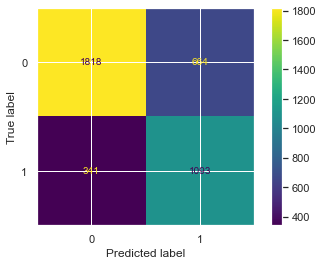

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      2482
           1       0.62      0.76      0.69      1434

    accuracy                           0.74      3916
   macro avg       0.73      0.75      0.73      3916
weighted avg       0.76      0.74      0.75      3916



In [99]:
df_1 = pd.DataFrame({'y_1_test': y_1_test, 'y_1_pred': pred_proba[:,1] > .4})
cm = confusion_matrix(y_1_test, df_1['y_1_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf_1.classes_)

disp.plot()
plt.show()

print(classification_report(y_1_test, df_1['y_1_pred']))

Precision has decreased, recall has increased, f1-score is almost the same. No improvement compared to the 0.5 threshold

### Threshold 0.5

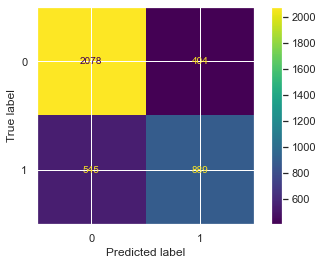

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2482
           1       0.69      0.62      0.65      1434

    accuracy                           0.76      3916
   macro avg       0.74      0.73      0.73      3916
weighted avg       0.75      0.76      0.75      3916



In [100]:
df_1 = pd.DataFrame({'y_1_test': y_1_test, 'y_1_pred': pred_proba[:,1] > .5})
cm = confusion_matrix(y_1_test, df_1['y_1_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf_1.classes_)

disp.plot()
plt.show()

print(classification_report(y_1_test, df_1['y_1_pred']))

Same values as for the initial model (which automatically starts with the 0.5 threshold)

### Threshold 0.7

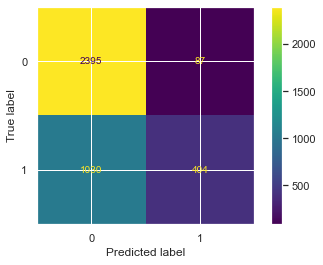

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2482
           1       0.82      0.28      0.42      1434

    accuracy                           0.71      3916
   macro avg       0.76      0.62      0.62      3916
weighted avg       0.74      0.71      0.67      3916



In [101]:
df_1 = pd.DataFrame({'y_1_test': y_1_test, 'y_1_pred': pred_proba[:,1] > .7})
cm = confusion_matrix(y_1_test, df_1['y_1_pred'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf_1.classes_)

disp.plot()
plt.show()

print(classification_report(y_1_test, df_1['y_1_pred']))

Precision increased, recall decreased a lot and f1-score has also decreased. 

## Conclusion

**The model with the features median_income and ocean_proximity is the best. Moreover the classification performs best with a 0.4 threshhold**

## The code below was based on the world happiness report, above I corrected the code and made it based on the online ads.

I did not want to delete this code, as it took me a while to create it, even though the code above is better

### Define x and y

In this model all variables (for x), except price_category and median_house_value (because they are already including the solution) are used for the classification
Goal is to make correct predictions for the price category (in this case the factorized price_category_2 is used for y)

In [102]:
# drop median house value (as it is will be included in y, drop price_category as we want to predict it and drop ocean_proximity as it will be added via the dummy variables)
X_numerical = df.drop(['median_house_value', 'price_category', 'price_category2', 'ocean_proximity'], axis=1).astype('float64')


In [103]:
list_numerical = X_numerical.columns
list_numerical

Index(['median_housing_age', 'population', 'households', 'median_income',
       'avg_rooms_per_household', 'avg_size_per_household'],
      dtype='object')

In [104]:
X = pd.concat([X_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

y = df.price_category2

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_housing_age          19579 non-null  float64
 1   population                  19579 non-null  float64
 2   households                  19579 non-null  float64
 3   median_income               19579 non-null  float64
 4   avg_rooms_per_household     19579 non-null  float64
 5   avg_size_per_household      19579 non-null  float64
 6   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 7   ocean_proximity_INLAND      19579 non-null  uint8  
 8   ocean_proximity_ISLAND      19579 non-null  uint8  
 9   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 10  ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(6), uint8(5)
memory usage: 1.6 MB


### Data Split

In [105]:
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=10)

In [106]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3916 entries, 11395 to 5013
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_housing_age          3916 non-null   float64
 1   population                  3916 non-null   float64
 2   households                  3916 non-null   float64
 3   median_income               3916 non-null   float64
 4   avg_rooms_per_household     3916 non-null   float64
 5   avg_size_per_household      3916 non-null   float64
 6   ocean_proximity_<1H OCEAN   3916 non-null   uint8  
 7   ocean_proximity_INLAND      3916 non-null   uint8  
 8   ocean_proximity_ISLAND      3916 non-null   uint8  
 9   ocean_proximity_NEAR BAY    3916 non-null   uint8  
 10  ocean_proximity_NEAR OCEAN  3916 non-null   uint8  
dtypes: float64(6), uint8(5)
memory usage: 233.3 KB


In [107]:
# check the length of the training and test size
print("Training size:", len(X_train))
print("Test size:", len(X_test))

Training size: 15663
Test size: 3916


### Train data

In [108]:
# Train logistic regression model with training set
logit = sm.Logit(y_train, X_train).fit()

         Current function value: inf
         Iterations: 35


C:\Users\Daniel\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Daniel\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [ ]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:        price_category2   No. Observations:                15663
Model:                          Logit   Df Residuals:                    15653
Method:                           MLE   Df Model:                            9
Date:                Sun, 16 Jan 2022   Pseudo R-squ.:                  0.4914
Time:                        10:15:37   Log-Likelihood:                -5305.7
converged:                      False   LL-Null:                       -10432.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
median_housing_age            -0.0190      0.002     -8.189      0.000      -0.024      -0.014
population                     0.0011   6.55e-05     17.019      0.000       0.001 

### Make predictions

In [ ]:
# create empty dataframe
data = pd.DataFrame()

# include prediction from test data
data['Probability'] = logit.predict(X_test)

In [ ]:
# Calculate metrics
# create different threshholds to analysze for which we get the best results
data['price_category'] = np.where(y_test == 1.0, 'below', 'above')  
data['Threshold 0.4'] = np.where(data['Probability'] > 0.4, 'below', 'above')  
data['Threshold 0.5'] = np.where(data['Probability'] > 0.5, 'below', 'above')  
data['Threshold 0.6'] = np.where(data['Probability'] > 0.6, 'below', 'above')  
data['Threshold 0.7'] = np.where(data['Probability'] > 0.7, 'below', 'above')  
data.head(7)

,Probability,price_category,Threshold 0.4,Threshold 0.5,Threshold 0.6,Threshold 0.7
11395,0.002542,above,above,above,above,above
2260,0.989510,below,below,below,below,below
12456,0.903785,below,below,below,below,below
16,0.350617,above,above,above,above,above
13065,0.538379,below,below,below,above,above
12596,0.923969,below,below,below,below,below
6732,0.000021,above,above,above,above,above


In [ ]:
# create the classification results with a confusion matrix and the Classification report
def print_metrics(df, predicted):
    # Header
    print('-'*50)
    print(f'Metrics for: {predicted}\n')
    
    # Confusion Matrix
    y_actu = pd.Series(df['price_category'], name='Actual')
    y_pred = pd.Series(df[predicted], name='Predicted')
    df_conf = pd.crosstab(y_actu, y_pred)
    display(df_conf)
    
    # Confusion Matrix to variables:
    pop = df_conf.values.sum()
    tp = df_conf['above']['above']
    tn = df_conf['below']['below']
    fp = df_conf['above']['below']
    fn = df_conf['below']['above']
    
    # Metrics
    accuracy = (tp + tn) / pop
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1_score:.4f} \n')

In [ ]:
print_metrics(data, 'Threshold 0.4')
print_metrics(data, 'Threshold 0.5')
print_metrics(data, 'Threshold 0.6')
print_metrics(data, 'Threshold 0.7')

--------------------------------------------------
Metrics for: Threshold 0.4



Predicted,above,below
Actual,,
above,2096,386
below,215,1219


Accuracy:  0.8465
Precision: 0.9070
Recall:    0.8445
F1 Score:  0.8746 

--------------------------------------------------
Metrics for: Threshold 0.5



Predicted,above,below
Actual,,
above,2201,281
below,295,1139


Accuracy:  0.8529
Precision: 0.8818
Recall:    0.8868
F1 Score:  0.8843 

--------------------------------------------------
Metrics for: Threshold 0.6



Predicted,above,below
Actual,,
above,2286,196
below,396,1038


Accuracy:  0.8488
Precision: 0.8523
Recall:    0.9210
F1 Score:  0.8854 

--------------------------------------------------
Metrics for: Threshold 0.7



Predicted,above,below
Actual,,
above,2345,137
below,518,916


Accuracy:  0.8327
Precision: 0.8191
Recall:    0.9448
F1 Score:  0.8775 



### Conclusion: 
The threshhold 0.6 delivers the best results (highstes F1-score).
I am using the F1-score because I want to have a model with both good precision and recall.
If the precision is low, the F1 is low and if the recall is low again the F1 score is low.

## Model with Median_income as only variable
### Define x and y

In this model only the variable which was analyzed in the correlation analysis is used. So only the median_income as x will be used here. 
Goal is to make correct predictions for the price category (in this case the factorized price_category_2 is used for y)



In [ ]:
# drop everything except median_income - somehow it did not work wenn I only used median_income and did not drop anything
X_1_numerical = df.drop(['median_housing_age', 'population', 'households', 'avg_rooms_per_household', 'median_house_value', 'price_category', 'price_category2', 'ocean_proximity'], axis=1).astype('float64')

In [ ]:
list_1_numerical = X_1_numerical.columns
list_1_numerical

Index(['median_income'], dtype='object')

In [ ]:
X_1 = X_1_numerical
y_1 = df.price_category2

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_housing_age          19579 non-null  float64
 1   population                  19579 non-null  float64
 2   households                  19579 non-null  float64
 3   median_income               19579 non-null  float64
 4   avg_rooms_per_household     19579 non-null  float64
 5   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 6   ocean_proximity_INLAND      19579 non-null  uint8  
 7   ocean_proximity_ISLAND      19579 non-null  uint8  
 8   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 9   ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(5), uint8(5)
memory usage: 1.5 MB


### Data Split

In [ ]:
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
from sklearn.model_selection import train_test_split

X_1_train, X_1_test, y_1_train, y_1_test =train_test_split(X_1, y_1, test_size=0.2, random_state=10)

X_1_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3916 entries, 11395 to 5013
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   median_income  3916 non-null   float64
dtypes: float64(1)
memory usage: 61.2 KB


In [ ]:
# check the length of the training and test size
print("Training size:", len(X_1_train))
print("Test size:", len(X_1_test))

Training size: 15663
Test size: 3916


### Train the model

In [ ]:
# Train logistic regression model with training set
logit_1 = sm.Logit(y_1_train, X_1_train).fit()

Optimization terminated successfully.
         Current function value: 0.598266
         Iterations 4


In [ ]:
print(logit_1.summary())

                           Logit Regression Results                           
Dep. Variable:        price_category2   No. Observations:                15663
Model:                          Logit   Df Residuals:                    15662
Method:                           MLE   Df Model:                            0
Date:                Sun, 16 Jan 2022   Pseudo R-squ.:                  0.1017
Time:                        10:15:38   Log-Likelihood:                -9370.6
converged:                       True   LL-Null:                       -10432.
Covariance Type:            nonrobust   LLR p-value:                       nan
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
median_income -2.282e-05   4.58e-07    -49.821      0.000   -2.37e-05   -2.19e-05


### Make predictions

In [ ]:
# create empty dataframe
data = pd.DataFrame()

# include prediction from test data
data['Probability1'] = logit_1.predict(X_1_test)

In [ ]:
# Calculate metrics
# create different threshholds to analysze for which we get the best results
data['price_category'] = np.where(y_test == 1.0, 'below', 'above')  
data['Threshold 0.4'] = np.where(data['Probability1'] > 0.4, 'below', 'above')  
data['Threshold 0.5'] = np.where(data['Probability1'] > 0.5, 'below', 'above')  
data['Threshold 0.6'] = np.where(data['Probability1'] > 0.6, 'below', 'above')  
data['Threshold 0.7'] = np.where(data['Probability1'] > 0.7, 'below', 'above')  
data.head(7)

,Probability1,price_category,Threshold 0.4,Threshold 0.5,Threshold 0.6,Threshold 0.7
11395,0.180391,above,above,above,above,above
2260,0.424217,below,below,above,above,above
12456,0.351698,below,above,above,above,above
16,0.346755,above,above,above,above,above
13065,0.260281,below,above,above,above,above
12596,0.368817,below,above,above,above,above
6732,0.096683,above,above,above,above,above


In [ ]:
# create the classification results with a confusion matrix and the Classification report
def print_metrics(df, predicted):
    # Header
    print('-'*50)
    print(f'Metrics for: {predicted}\n')
    
    # Confusion Matrix
    y_actu = pd.Series(df['price_category'], name='Actual')
    y_pred = pd.Series(df[predicted], name='Predicted')
    df_conf = pd.crosstab(y_actu, y_pred)
    display(df_conf)
    
    # Confusion Matrix to variables:
    pop = df_conf.values.sum()
    tp = df_conf['above']['above']
    tn = df_conf['below']['below']
    fp = df_conf['above']['below']
    fn = df_conf['below']['above']
    
    # Metrics
    accuracy = (tp + tn) / pop
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1_score:.4f} \n')

In [ ]:
print_metrics(data, 'Threshold 0.4')
print_metrics(data, 'Threshold 0.5')
print_metrics(data, 'Threshold 0.6')
print_metrics(data, 'Threshold 0.7')

--------------------------------------------------
Metrics for: Threshold 0.4



Predicted,above,below
Actual,,
above,2436,46
below,1188,246


Accuracy:  0.6849
Precision: 0.6722
Recall:    0.9815
F1 Score:  0.7979 

--------------------------------------------------
Metrics for: Threshold 0.5



Predicted,above
Actual,
above,2482
below,1434


KeyError: 'below'

### Conclusion: 
No conclusion possible due to the error...

## Model with results from feature selection
### Define x and y

In this model only the variables which were analyzed in the feature selection are used. So only the median_income and ocean_proximity as x will be used here. 
Goal is to make correct predictions for the price category (in this case the factorized price_category_2 is used for y)

In [ ]:
# drop everything except median_income - somehow it did not work wenn I only used median_income and did not drop anything
X_2_numerical = df.drop(['median_housing_age', 'population', 'households', 'avg_rooms_per_household', 'median_house_value', 'price_category', 'price_category2', 'ocean_proximity'], axis=1).astype('float64')

In [ ]:
list_2_numerical = X_2_numerical.columns
list_2_numerical

Index(['median_income'], dtype='object')

Adding the dummy variables

In [ ]:
X_2 = pd.concat([X_2_numerical, dummies[['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']]], axis=1)

y_2 = df.price_category2

X_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19579 entries, 0 to 20639
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_income               19579 non-null  float64
 1   ocean_proximity_<1H OCEAN   19579 non-null  uint8  
 2   ocean_proximity_INLAND      19579 non-null  uint8  
 3   ocean_proximity_ISLAND      19579 non-null  uint8  
 4   ocean_proximity_NEAR BAY    19579 non-null  uint8  
 5   ocean_proximity_NEAR OCEAN  19579 non-null  uint8  
dtypes: float64(1), uint8(5)
memory usage: 917.6 KB


### Data Split

In [ ]:
# Use random_state=10 to make this notebook's output identical at every run, test size shall be 20%
from sklearn.model_selection import train_test_split

X_2_train, X_2_test, y_2_train, y_2_test =train_test_split(X_2, y_2, test_size=0.2, random_state=10)

In [ ]:
X_2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3916 entries, 11395 to 5013
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   median_income               3916 non-null   float64
 1   ocean_proximity_<1H OCEAN   3916 non-null   uint8  
 2   ocean_proximity_INLAND      3916 non-null   uint8  
 3   ocean_proximity_ISLAND      3916 non-null   uint8  
 4   ocean_proximity_NEAR BAY    3916 non-null   uint8  
 5   ocean_proximity_NEAR OCEAN  3916 non-null   uint8  
dtypes: float64(1), uint8(5)
memory usage: 80.3 KB


In [ ]:
# check the length of the training and test size
print("Training size:", len(X_2_train))
print("Test size:", len(X_2_test))

Training size: 15663
Test size: 3916


In [ ]:
# Train logistic regression model with training set
logit_2 = sm.Logit(y_2_train, X_2_train).fit()

         Current function value: 0.354376
         Iterations: 35


C:\Users\Daniel\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(logit_2.summary())

                           Logit Regression Results                           
Dep. Variable:        price_category2   No. Observations:                15663
Model:                          Logit   Df Residuals:                    15657
Method:                           MLE   Df Model:                            5
Date:                Sat, 08 Jan 2022   Pseudo R-squ.:                  0.4679
Time:                        13:42:45   Log-Likelihood:                -5550.6
converged:                      False   LL-Null:                       -10432.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
median_income                 -0.0001   2.57e-06    -51.859      0.000      -0.000      -0.000
ocean_proximity_<1H OCEAN      2.8863      0.082     35.070      0.000       2.725 

In [ ]:
# create empty dataframe
data = pd.DataFrame()

# include prediction from test data
data['Probability2'] = logit_2.predict(X_2_test)

In [ ]:
# Calculate metrics
# create different threshholds to analysze for which we get the best results
data['price_category'] = np.where(y_2_test == 1.0, 'below', 'above')  
data['Threshold 0.4'] = np.where(data['Probability2'] > 0.4, 'below', 'above')  
data['Threshold 0.5'] = np.where(data['Probability2'] > 0.5, 'below', 'above')  
data['Threshold 0.6'] = np.where(data['Probability2'] > 0.6, 'below', 'above')  
data['Threshold 0.7'] = np.where(data['Probability2'] > 0.7, 'below', 'above')  
data.head(7)

,Probability2,price_category,Threshold 0.4,Threshold 0.5,Threshold 0.6,Threshold 0.7
11395,0.002624,above,above,above,above,above
2260,0.983935,below,below,below,below,below
12456,0.911332,below,below,below,below,below
16,0.363337,above,above,above,above,above
13065,0.451541,below,below,above,above,above
12596,0.940654,below,below,below,below,below
6732,0.000039,above,above,above,above,above


In [ ]:
# create the classification results with a confusion matrix and the Classification report
def print_metrics(df, predicted):
    # Header
    print('-'*50)
    print(f'Metrics for: {predicted}\n')
    
    # Confusion Matrix
    y_actu = pd.Series(df['price_category'], name='Actual')
    y_pred = pd.Series(df[predicted], name='Predicted')
    df_conf = pd.crosstab(y_actu, y_pred)
    display(df_conf)
    
    # Confusion Matrix to variables:
    pop = df_conf.values.sum()
    tp = df_conf['above']['above']
    tn = df_conf['below']['below']
    fp = df_conf['above']['below']
    fn = df_conf['below']['above']
    
    # Metrics
    accuracy = (tp + tn) / pop
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1_score:.4f} \n')

In [ ]:
print_metrics(data, 'Threshold 0.4')
print_metrics(data, 'Threshold 0.5')
print_metrics(data, 'Threshold 0.6')
print_metrics(data, 'Threshold 0.7')

--------------------------------------------------
Metrics for: Threshold 0.4



Predicted,above,below
Actual,,
above,2077,405
below,232,1202


Accuracy:  0.8373
Precision: 0.8995
Recall:    0.8368
F1 Score:  0.8670 

--------------------------------------------------
Metrics for: Threshold 0.5



Predicted,above,below
Actual,,
above,2205,277
below,311,1123


Accuracy:  0.8498
Precision: 0.8764
Recall:    0.8884
F1 Score:  0.8824 

--------------------------------------------------
Metrics for: Threshold 0.6



Predicted,above,below
Actual,,
above,2300,182
below,442,992


Accuracy:  0.8407
Precision: 0.8388
Recall:    0.9267
F1 Score:  0.8806 

--------------------------------------------------
Metrics for: Threshold 0.7



Predicted,above,below
Actual,,
above,2351,131
below,557,877


Accuracy:  0.8243
Precision: 0.8085
Recall:    0.9472
F1 Score:  0.8724 



### Conclusion

Somehow the results for model 2 are not working...
So I can only compare it with model 1.

This model delivers the best results for a threshold of 0.5. Here the F1-Score is 0.8824, which is slightly lower as the F1-score of model 1 (threshold 0.6): 0.8843.
--> Model 1 is superior 